# Preprocessing, Feature Engineering, and Non-Linear Classifiers
In this lab we are going to train a classifier to predict which passengers survived the Titanic based on demographic information and travel details. 

This is a great dataset for learning the importance of feature engineering. Providing the model with informative features is critical to achieving high performance. 

First, we will try fitting some classifiers without doing any data engineering other than imputation and encoding categorical features. 

In the second half of the lab, you will engineer new features and hopefully gain an intuition on how we devise features that are informative to the ML task. 

We will also experiment with several models that you have been reviewing in class: LogisticRegression, RandomForest, XGBoost, SVC, NaiveBayes, and K-NN.

### Import the libraries
You may need to install `xgboost` if you do not already have it. The conda environment file in the cell below can be used to match package versions used to generate this notebook.
Use the command `conda update --file ./enviornment.yaml` to update an existing conda env or create a new one using `conda env create --file ./environment.yaml`

```
name: ensf444
channels:
  - defaults
  - conda-forge
dependencies:
  - python=3.10.13
  - seaborn=0.13.*
  - matplotlib
  - pandas=2.*
  - numpy
  - scikit-learn=1.4.*
  - jupyter
  - kaggle
  - xgboost=1.7.*
```

In [192]:
from __future__ import annotations
import pathlib
from dataclasses import dataclass
from typing import Dict, List, Any
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier

In [193]:
### Constants
_RANDOM_STATE = 42
_DATA_PATH = pathlib.Path("../data") / "lab-5"  # Note functionality of division operator (__truediv__) on Path objects
_DATA_PATH

PosixPath('../data/lab-5')

### Data Ingestion

Either download the dataset from Kaggle ([link](https://www.kaggle.com/competitions/titanic/data?select=train.csv)) and use the train.csv or import it with the following line:

In [194]:
# Optional, import data with kaggle API
def get_kaggle_comp(comp_name: str, path: pathlib.Path) -> None:
        
    try: 
        import kaggle
        kaggle.api.authenticate()
        kaggle.api.competition_download_files(comp_name, path=path)
    except ModuleNotFoundError as e:
        print("Kaggle not installed, use 'pip install kaggle' or " 
            "'conda install -c conda-forge kaggle' and restart Jupyter kernel. "
            "Otherwise, download data and place in folder above manually"
        )
        print(e.message())
    except Exception as e:
        raise e

def unzip_file(path: pathlib.Path, fname:str) -> None:
    with zipfile.ZipFile(path / fname, "r") as handle:
        handle.extractall(path)

get_kaggle_comp("Titanic", _DATA_PATH)
unzip_file(_DATA_PATH, "titanic.zip")

In [195]:
import zipfile
fname = "titanic.zip"
with zipfile.ZipFile(_DATA_PATH / fname, "r") as handle:
    handle.extractall(_DATA_PATH)

In [196]:
# Load the Titanic train datasets
df = pd.read_csv(_DATA_PATH/"train.csv", index_col="PassengerId")

In [197]:
# For this notebook we are going to pretend that we have a "real" hold-out test set
# We will start by using numpy to split our dataset
np.random.seed(_RANDOM_STATE)
indices = np.arange(len(df))
indices = np.random.permutation(indices)
train_indices = indices[:int(len(indices)*0.8)]
test_indices = indices[int(len(indices)*0.8):]

In [198]:
train_df = df.iloc[train_indices].copy()
test_df = df.iloc[test_indices].copy()
assert len(train_df) + len(test_df) == len(df)

In [199]:
# Explore the first few rows of the dataset
train_df.head()

Survived  Pclass  \
PassengerId                     
710                 1       3   
440                 0       2   
841                 0       3   
721                 1       2   
40                  1       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
710          Moubarek, Master. Halim Gonios ("William George")    male   NaN   
440                     Kvillner, Mr. Johan Henrik Johannesson    male  31.0   
841                                Alhomaki, Mr. Ilmari Rudolf    male  20.0   
721                          Harper, Miss. Annie Jessie "Nina"  female   6.0   
40                                 Nicola-Yarred, Miss. Jamila  female  14.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
710              1      1              2661  15.2458   NaN        C  
440              0      0        C.A. 18723  10.5000   NaN        S  
841              0      0  SOTON/O2 3101287   7.9250   NaN        S  
721              0      1            248727  33.0000   NaN        S  
40               1      0              2651  11.2417   NaN        C

### What do these features mean?

| Variable  | Definition                  | Key                                                |
|-----------|-----------------------------|-----------------------------------------------------|
| survival  | Survival                    | 0 = No, 1 = Yes                                    |
| pclass    | Ticket class                | 1 = 1st, 2 = 2nd, 3 = 3rd                           |
| sex       | Sex                         |                                                     |
| Age       | Age in years                |                                                     |
| sibsp     | # of siblings/spouses aboard the Titanic        |                                 |
| parch     | # of parents/children aboard the Titanic         |                                |
| ticket    | Ticket number               |                                                     |
| fare      | Passenger fare              |                                                     |
| cabin     | Cabin number                |                                                     |
| embarked  | Port of Embarkation         | C = Cherbourg, Q = Queenstown, S = Southampton     |


# Data Preprocessing

In [200]:
# Get a summary of the dataset with .info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 710 to 804
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Name      712 non-null    object 
 3   Sex       712 non-null    object 
 4   Age       568 non-null    float64
 5   SibSp     712 non-null    int64  
 6   Parch     712 non-null    int64  
 7   Ticket    712 non-null    object 
 8   Fare      712 non-null    float64
 9   Cabin     158 non-null    object 
 10  Embarked  710 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [201]:
# Which features need to be encoded?
# Name, Sex, Ticket, Cabin, Embarked

In [202]:
# Summary statistics for numerical columns
train_df.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  712.000000  712.000000  568.000000  712.000000  712.000000  712.000000
mean     0.389045    2.313202   29.538151    0.519663    0.411517   33.001761
std      0.487876    0.832832   14.947113    1.078967    0.833903   52.353275
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.375000    0.000000    0.000000    7.925000
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.500000
75%      1.000000    3.000000   38.000000    1.000000    1.000000   31.068750
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

### Missing value imputation

In [203]:
# Count the number of missing values in each column
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         144
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       554
Embarked      2
dtype: int64

In [204]:
test_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age          33
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       133
Embarked      0
dtype: int64

In [205]:
# Let's simply fill missing Age's with the mean age. 
train_df.loc[:, 'Age'] = train_df['Age'].fillna(value=train_df['Age'].mean())

# NOTE: Since the test_df is intended to be "unseen", fill it's missing values with the values calculated using the training dataset
test_df.loc[:, 'Age'] = test_df['Age'].fillna(value=train_df['Age'].mean())

In [206]:
# What relationships might Age have with other variables? How could we fill missing values more accurately?

In [207]:
# Let's simply fill missing cabin values with a sentential value, 'UNK'
train_df.loc[:, 'Cabin'] = train_df["Cabin"].fillna(value="UNK")
test_df.loc[:, 'Cabin'] = test_df["Cabin"].fillna(value="UNK")

In [208]:
# We can do the same thing for embarked:
train_df.loc[:, 'Embarked'] = train_df["Embarked"].fillna(value="UNK")
test_df.loc[:, 'Embarked'] = test_df["Embarked"].fillna(value="UNK")

In [209]:
# Confirm no more NaNs?
print(f"Any nulls in train_df: {train_df.isnull().any().any()}")
print(f"Any nulls in test_df: {test_df.isnull().any().any()}")

Any nulls in train_df: False
Any nulls in test_df: False


### Categorical Feature Encoding

In [210]:
# We need to either encode OR drop the following:
train_df.select_dtypes("O")

Name     Sex  \
PassengerId                                                              
710          Moubarek, Master. Halim Gonios ("William George")    male   
440                     Kvillner, Mr. Johan Henrik Johannesson    male   
841                                Alhomaki, Mr. Ilmari Rudolf    male   
721                          Harper, Miss. Annie Jessie "Nina"  female   
40                                 Nicola-Yarred, Miss. Jamila  female   
...                                                        ...     ...   
506                 Penasco y Castellana, Mr. Victor de Satode    male   
640                                 Thorneycroft, Mr. Percival    male   
879                                         Laleff, Mr. Kristo    male   
825                               Panula, Master. Urho Abraham    male   
804                            Thomas, Master. Assad Alexander    male   

                       Ticket Cabin Embarked  
PassengerId                                   
710                      2661   UNK        C  
440                C.A. 18723   UNK        S  
841          SOTON/O2 3101287   UNK        S  
721                    248727   UNK        S  
40                       2651   UNK        C  
...                       ...   ...      ...  
506                  PC 17758   C65        C  
640                    376564   UNK        S  
879                    349217   UNK        S  
825                   3101295   UNK        S  
804                      2625   UNK        C  

[712 rows x 5 columns]

In [211]:
# Which of these features are ordinal? 
# None! Therefore, we need to use one-hot encoding (OHE)

In [212]:
# One risk of OHE is blowing up the dimensionality of the dataset. 
# As a general rule of thumb, we typically do not want more features than samples
# Let's plot the number of unique instances per categorical feature:

for col in train_df.select_dtypes("O"):
    print(f"{col}: {len(train_df[col].unique())}")

Name: 712
Sex: 2
Ticket: 562
Cabin: 121
Embarked: 4


What can we conclude?
* Names are unique to each passenger. (What about surnames?)
* Sex can easily be encoded with OHE
* Most tickets are unique, but not all
* There are approximately 6 passengers per cabin (712/121)

Let's drop ticket and name. We can use ohe to encode the other variables

In [213]:
train_df = train_df.drop(columns=["Ticket", "Name"])
test_df = test_df.drop(columns=["Ticket", "Name"])

In [214]:
def ohe_encoding(df: pd.DataFrame, ohe: OneHotEncoder, cols: List[str]) -> pd.DataFrame:
    df = df.copy(deep=True)
    encoding = ohe.transform(df[cols])
    df = df.drop(columns=cols)
    df = pd.concat((df, encoding), axis=1)
    return df

cols = ["Embarked", "Sex", "Cabin"]
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int8).set_output(transform="pandas")
# NOTE: We need to set handle_unknown to 'ignore' since many cabins from test are not found in train
ohe.fit(train_df[cols])
train_df_encoded = ohe_encoding(train_df, ohe, cols)
test_df_encoded = ohe_encoding(test_df, ohe, cols)  

In [215]:
# NOTE: We transform test_df using same ohe as we fit to train df, this ensures 
# that the column indices match for each category. Consider what happens if you 
# call pd.get_dummies() on both train and test separately? What happens to unknown values?

In [216]:
# Quick check to confirm things were encoded correctly:
passenger = train_df.iloc[0]
encoded_pass = train_df_encoded.iloc[0]
display(passenger[['Sex', 'Embarked', 'Cabin']])
display(encoded_pass[['Sex_male', 'Embarked_C', 'Cabin_UNK']])

Sex         male
Embarked       C
Cabin        UNK
Name: 710, dtype: object

Sex_male      1.0
Embarked_C    1.0
Cabin_UNK     1.0
Name: 710, dtype: float64

In [217]:
# Great, let's overwrite references to old dfs:
train_df = train_df_encoded
test_df = test_df_encoded

# Modelling w/o engineered or scaled features

In [218]:
# Split train_df into train and validation splits
X_train = train_df.drop(columns=["Survived"])
y_train = train_df["Survived"]
X_test = test_df.drop(columns=["Survived"])
y_test = test_df["Survived"]

In [219]:
# Initalize our models with default hyperparameters, except for random state
# We will wrap this into a function so we can easily re-init new models in next phase
def get_models_dict() -> Dict[str, BaseEstimator]:
    lr = LogisticRegression()
    rf = RandomForestClassifier(random_state=_RANDOM_STATE)
    xgb = XGBClassifier(random_state=_RANDOM_STATE)
    nb = GaussianNB()
    svc = SVC(random_state=_RANDOM_STATE, probability=True)
    models_dict = {k.__class__.__name__: k for k in [lr, rf, xgb, nb, svc]}
    return models_dict

models_dict = get_models_dict()
models_dict

{'LogisticRegression': LogisticRegression(),
 'RandomForestClassifier': RandomForestClassifier(random_state=42),
 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...),
 'GaussianNB': GaussianNB(),
 'SVC': SVC(probability=True, random_state=42)}

In [220]:
# Let's define some helpers to fit and validate a model:
@dataclass(init=True)
class ModelMetrics():
    name: str
    acc: float
    cm: np.array
    roc_auc: float
    fpr: np.array
    tpr: np.array
    
    def display(self) -> None:
        print(f"{self.name} accuracy: {self.acc*100:.2f}%")
        print(f"{self.name} ROC-AUC: {self.roc_auc:.2f}")
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
        sns.heatmap(self.cm,
                    annot=True,
                    xticklabels=["Died", "Survived"],
                    yticklabels=["Died", "Survived"],
                    ax=ax1)
        ax1.set_ylabel("Actual")
        ax1.set_xlabel("Predicted")
        ax2.plot(self.fpr, self.tpr, label="ROC Curve")
        ax2.plot([0,1],[0,1], color='r', label="Random Chance", linestyle="--")
        plt.legend()
        display(fig)
        plt.close()

    @classmethod
    def display_all(cls, metrics: Dict[str, ModelMetrics]) -> None:
        accs = [m.acc for m in metrics.values()]
        roc_aucs = [m.roc_auc for m in metrics.values()]
        names = [m.name for m in metrics.values()]
        results = pd.DataFrame({
            "Accuracy": accs,
            "ROC_AUC": roc_aucs,
            "Name": names
        })
        display(results.sort_values(by='Accuracy', ascending=False))
        fig, ax = plt.subplots(figsize=(6,6))
        for m in metrics.values():
            ax.plot(m.fpr, m.tpr, label=m.name)
        ax.plot([0,1],[0,1], color='black', label="Random Chance", linestyle="--", alpha=0.5)
        ax.set_xlabel("False Positive Rate")
        ax.set_xlabel("True Positive Rate")
        plt.legend()
        display(fig)
        plt.close()

def fit_validate_model(model: BaseEstimator,
                       model_name: str,
                       X_train: pd.DataFrame,
                       X_test:pd.DataFrame,
                       y_train: pd.Series,
                       y_test: pd.Series) -> ModelMetrics:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)
    acc  = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores[:, 1])
    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1])
    return ModelMetrics(model_name, acc, cm, roc_auc, fpr, tpr)

data = [X_train, X_test, y_train, y_test]
naive_metrics = {}
for name, model in models_dict.items():
    naive_metrics[name] = fit_validate_model(model, name, *data)


/home/mike/miniconda3/envs/ensf444/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression accuracy: 80.45%
LogisticRegression ROC-AUC: 0.87


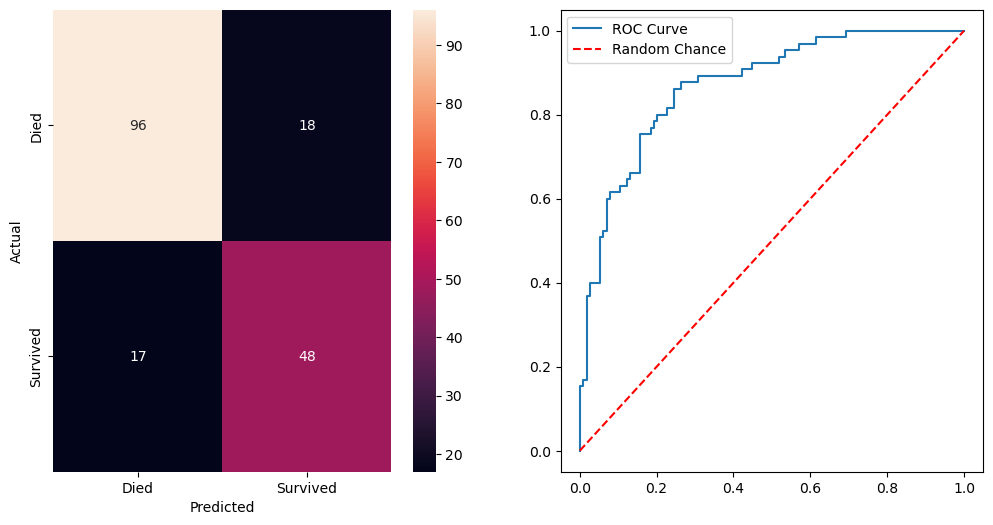

RandomForestClassifier accuracy: 86.03%
RandomForestClassifier ROC-AUC: 0.88


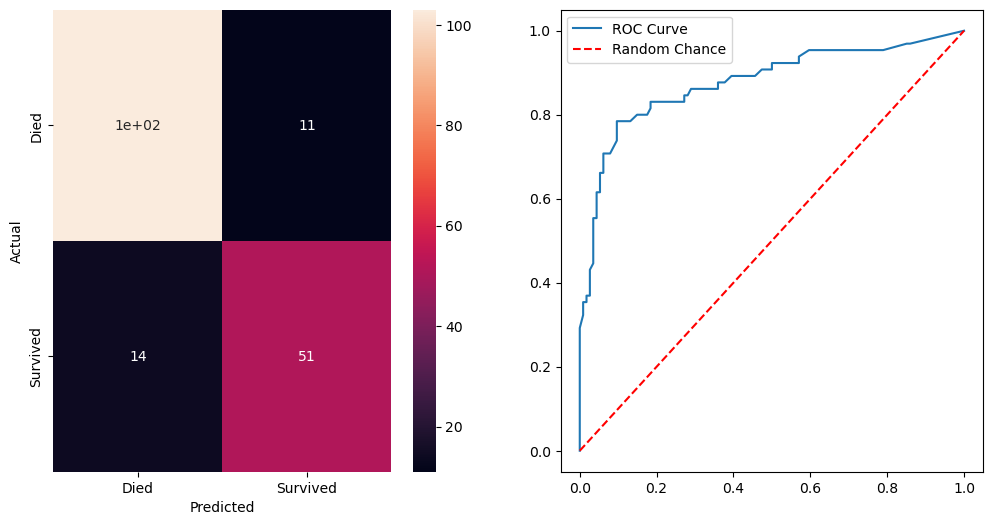

XGBClassifier accuracy: 82.68%
XGBClassifier ROC-AUC: 0.86


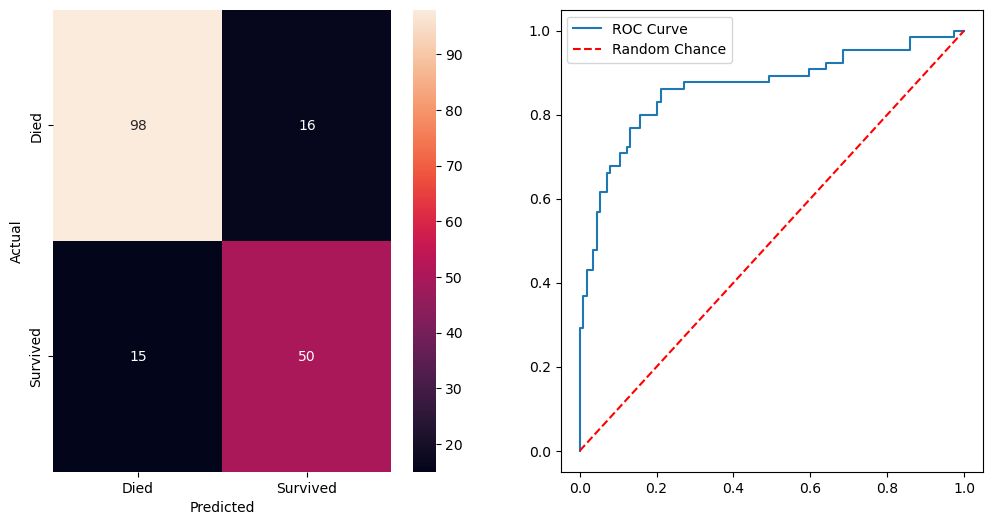

GaussianNB accuracy: 66.48%
GaussianNB ROC-AUC: 0.83


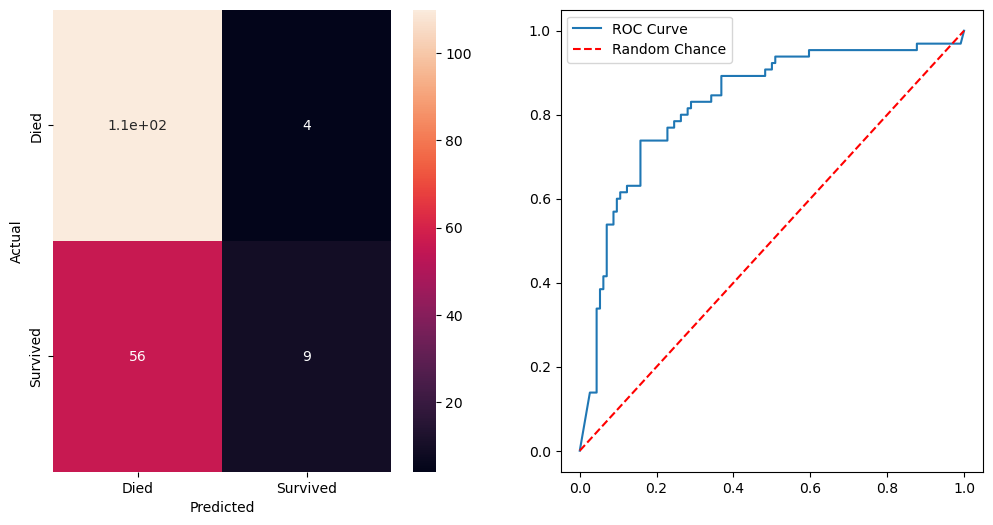

SVC accuracy: 68.72%
SVC ROC-AUC: 0.74


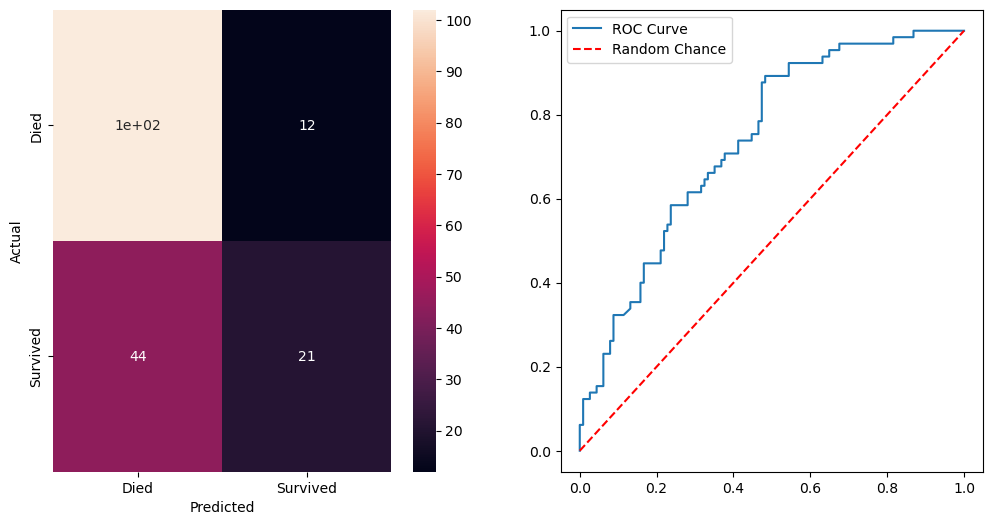

In [221]:
for _, m in naive_metrics.items():
    m.display()

Accuracy   ROC_AUC                    Name
1  0.860335  0.876721  RandomForestClassifier
2  0.826816  0.863698           XGBClassifier
0  0.804469  0.871255      LogisticRegression
4  0.687151  0.737652                     SVC
3  0.664804  0.828138              GaussianNB

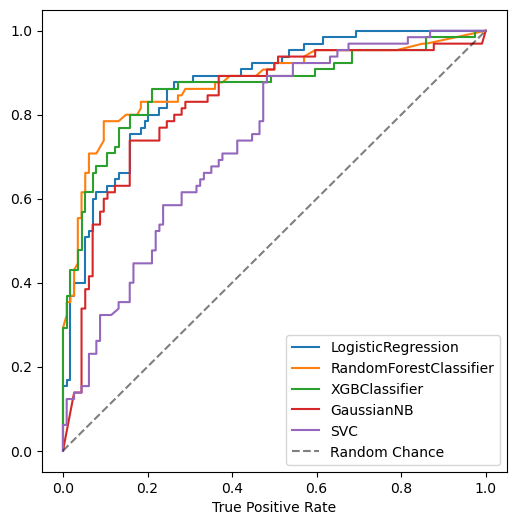

In [222]:
ModelMetrics.display_all(naive_metrics)

In [223]:
# Which model should we select?

# Your Turn!
Your goal is to *beat* the performance of the best model above by engineering new features. 

First we will perform an exploratory data analysis (EDA) to gain an intuition as to which features may be useful

We will first download the [*Starship Titantic*](https://www.kaggle.com/competitions/spaceship-titanic/data) Dataset from kaggle. It is similar to the original Titantic dataset and
we will use it to illustrate some of the transformations we will be using

NOTE: You must join competition to download this dataset!

### Data Ingestion

In [224]:
# Can also manually download and load
fname = "spaceship-titanic"
get_kaggle_comp(fname, _DATA_PATH/"space")
unzip_file(_DATA_PATH/"space", fname+".zip")

In [225]:
space_df = pd.read_csv(_DATA_PATH / "space" / "train.csv", index_col='PassengerId')
space_df.head()

HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                         
0001_01         Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
0002_01          Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
0003_02         Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
0004_01          Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   

                          Name  Transported  
PassengerId                                  
0001_01        Maham Ofracculy        False  
0002_01           Juanna Vines         True  
0003_01          Altark Susent        False  
0003_02           Solam Susent        False  
0004_01      Willy Santantines         True

In [226]:
# Let's also reload the original data and use the same train/test split
df = pd.read_csv(_DATA_PATH/"train.csv", index_col="PassengerId")
train_df = df.iloc[train_indices].copy()
test_df = df.iloc[test_indices].copy()

# Now we have train_df and test_df that you will be using. 
# We will demo transformations with space_df

### Exploratory Data Analysis
EDA is useful to help us find trends and inter-feature relationships. We will use information we learn during EDA to better inform our missing data imputation and feature engineering

In [227]:
train_df.isna().sum().sort_values(ascending=False)

Cabin       554
Age         144
Embarked      2
Name          0
Pclass        0
Survived      0
Sex           0
Parch         0
SibSp         0
Fare          0
Ticket        0
dtype: int64

In [228]:
# Recall that we had to fill missing values in Cabin, Age, and Embarked
# Was there a better way to do this? let's look for correlations

In [229]:
space_df.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported'],
      dtype='object')

<Axes: xlabel='Age', ylabel='Count'>

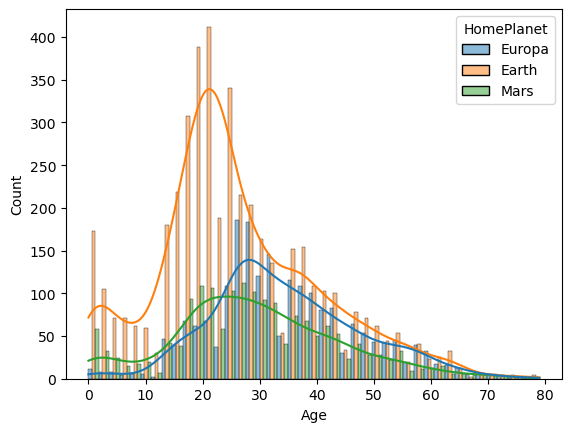

In [230]:
# SPACESHIP TITANIC EXAMPLE
# Plot histogram of age with hue set to "HomePlanet", kde=True, and multiple="dodge"
# What can we say about the distributions of ages? Are they correlated with HomePlanet?

sns.histplot(space_df, x="Age", kde=True, hue="HomePlanet", multiple="dodge")

<Axes: xlabel='Age', ylabel='Count'>

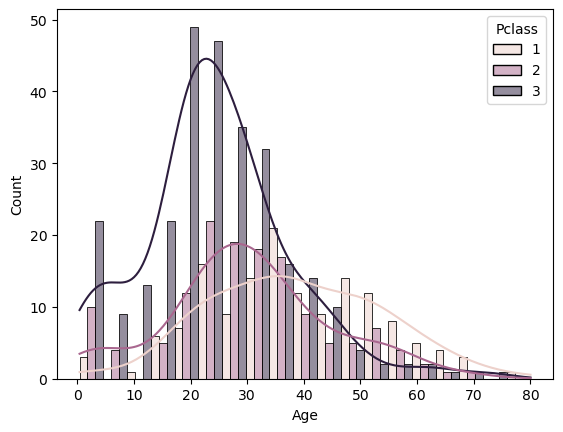

In [231]:
# Plot histogram (sns.histplot) of Age with hue set to Pclass, kde=True, and multiple='dodge'
sns.histplot(train_df, x="Age", kde=True, hue='Pclass', multiple='dodge')
# What can we conclude? Can we fill the ages in a more sensible manner?

In [232]:
# Next up is Cabin!
#Let's see unique values:
train_df['Cabin'].unique()

array([nan, 'D47', 'C123', 'D28', 'D19', 'C110', 'A6', 'D48', 'B69',
       'B96 B98', 'E68', 'B58 B60', 'E77', 'D20', 'B57 B59 B63 B66',
       'C148', 'E49', 'B39', 'F33', 'E34', 'A7', 'D36', 'E36', 'D50',
       'C126', 'D', 'B49', 'E63', 'A31', 'C92', 'E25', 'C95', 'A5', 'D15',
       'D7', 'D17', 'B86', 'A20', 'B78', 'B30', 'D21', 'D10 D12', 'G6',
       'C124', 'B38', 'C52', 'C93', 'C45', 'B20', 'C82', 'C78', 'C106',
       'C22 C26', 'B28', 'C104', 'F2', 'D11', 'C86', 'E38', 'A34', 'C91',
       'C68', 'F G73', 'E46', 'E50', 'A32', 'C128', 'E10', 'E44', 'B41',
       'B18', 'D35', 'E31', 'C2', 'C50', 'C103', 'B3', 'A10', 'C49',
       'C90', 'B77', 'E33', 'B5', 'A19', 'B37', 'E58', 'C23 C25 C27',
       'C7', 'E67', 'E8', 'B22', 'B35', 'C125', 'C65', 'C54', 'B80',
       'B94', 'D26', 'E121', 'E24', 'D45', 'B101', 'B51 B53 B55', 'D46',
       'E17', 'B4', 'C46', 'A23', 'F4', 'C47', 'E101', 'C111', 'C101',
       'B82 B84', 'C70', 'C32', 'B102', 'B71', 'A36', 'D9', 'B50'],
      

In [233]:
# These are in the format <deck-letter><cabin-number>
# NOTE: we have some messy entries with multiple cabins, but these are rare
# Let's see if we can gain some understanding by examining relationships with the deck

In [234]:
# SPACESHIP TITANIC EXAMPLE
# Extract first letter of cabin and assign to new feature named "Deck"
space_df['Deck'] = space_df['Cabin'].apply(lambda x: x[0] if x is not np.NaN else x)
space_df[['Deck', 'Cabin']].head()

Deck  Cabin
PassengerId            
0001_01        B  B/0/P
0002_01        F  F/0/S
0003_01        A  A/0/S
0003_02        A  A/0/S
0004_01        F  F/1/S

In [235]:
# Your turn, don't forget test_df!
train_df['Deck'] = train_df['Cabin'].apply(lambda x: x[0] if x is not np.NaN else x)
test_df['Deck'] = test_df['Cabin'].apply(lambda x: x[0] if x is not np.NaN else x)
train_df[['Deck', 'Cabin']]

Deck Cabin
PassengerId           
710          NaN   NaN
440          NaN   NaN
841          NaN   NaN
721          NaN   NaN
40           NaN   NaN
...          ...   ...
506            C   C65
640          NaN   NaN
879          NaN   NaN
825          NaN   NaN
804          NaN   NaN

[712 rows x 2 columns]

<Axes: xlabel='Deck', ylabel='RoomService'>

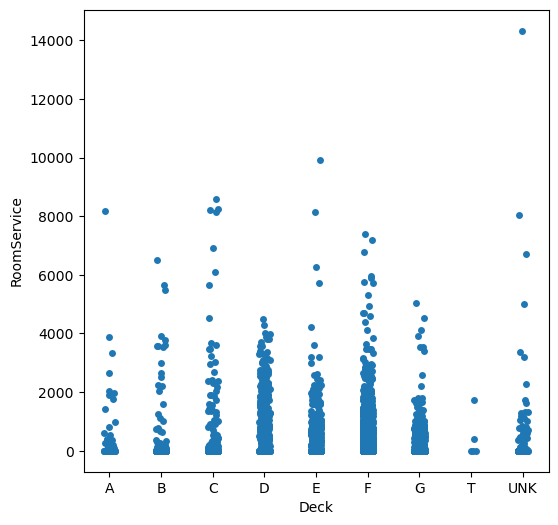

In [236]:
# SPACESHIP TITANIC EXAMPLE
# Plot seaborn strip plot of RoomService vs. Deck. 
# Encoding missing values as UNK but do not overwrite original DataFrame yet
fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(
    x=space_df.sort_values(by='Deck')['Deck'].fillna("UNK"),
    y=space_df.sort_values(by='Deck')['RoomService']
    )

<Axes: xlabel='Deck', ylabel='Fare'>

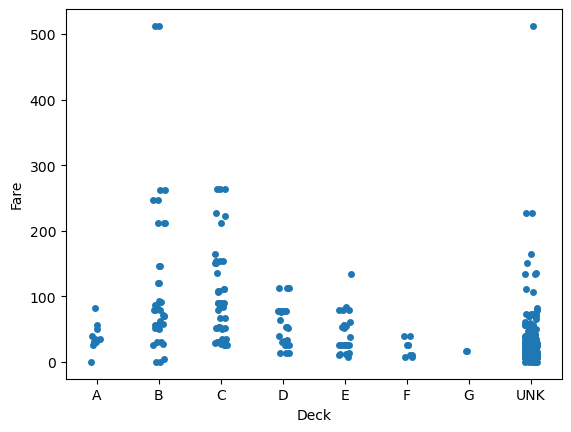

In [237]:
# Plot scatter plot of Fare vs. Deck
sns.stripplot(x=train_df.sort_values(by='Deck')['Deck'].fillna("UNK"), y=train_df.sort_values(by='Deck')['Fare'])

In [238]:
# Seems that missing cabin values are typically lower fare passengers! Let's look for other relations
# Perhaps we can use the mean fare on each deck to fill in the missing values!

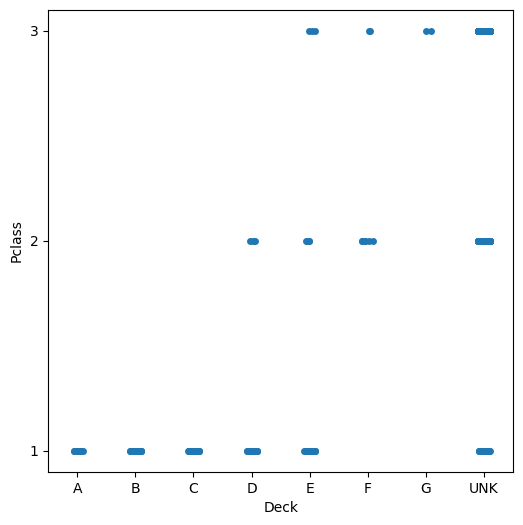

In [239]:
# Let's try Pclass
fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(x=train_df.sort_values(by='Deck')['Deck'].fillna("UNK"), y=train_df.sort_values(by='Deck')['Pclass'],ax=ax)
_ = ax.set_yticks([1,2,3])

In [240]:
# No clear relationship here!
# What other relationships might we try? What about the name feature?

In [241]:
# SPACESHIP TITANIC EXAMPLE
# Create new feature named "Surname"
# NOTE: If lambda is confusing you can also define a function to call!
space_df['Surname'] = space_df['Name'].str.split(" ").apply(lambda x: x if x is np.NaN else x[-1].strip())
space_df[['Name', 'Surname']].head()

Name      Surname
PassengerId                                
0001_01        Maham Ofracculy    Ofracculy
0002_01           Juanna Vines        Vines
0003_01          Altark Susent       Susent
0003_02           Solam Susent       Susent
0004_01      Willy Santantines  Santantines

In [242]:
# NOTE: Surname is your dataset is first! How to modify the above?
# Hint: We need to split on a different delimiter!
train_df['Name'].head()

PassengerId
710    Moubarek, Master. Halim Gonios ("William George")
440               Kvillner, Mr. Johan Henrik Johannesson
841                          Alhomaki, Mr. Ilmari Rudolf
721                    Harper, Miss. Annie Jessie "Nina"
40                           Nicola-Yarred, Miss. Jamila
Name: Name, dtype: object

In [243]:
# Your turn, don't forget test_df

train_df['Surname'] = train_df['Name'].str.split(",").apply(lambda x: x if x is np.NaN else x[0].strip())
test_df['Surname'] = test_df['Name'].str.split(",").apply(lambda x: x if x is np.NaN else x[0].strip())
train_df[['Name', 'Surname']].head()

Name        Surname
PassengerId                                                                  
710          Moubarek, Master. Halim Gonios ("William George")       Moubarek
440                     Kvillner, Mr. Johan Henrik Johannesson       Kvillner
841                                Alhomaki, Mr. Ilmari Rudolf       Alhomaki
721                          Harper, Miss. Annie Jessie "Nina"         Harper
40                                 Nicola-Yarred, Miss. Jamila  Nicola-Yarred

In [244]:
# OPTIONAL: We can also see that the names include the titles of passengers 
# (Mr. Miss, etc.). However, these are harder to extract from Name string

# Create a new feature named "Title" similar to the above. 
# NOTE: Try using pd.Series.str.extract method with regex pattern r"([A-Z]*[a-z]*)\."
# NOTE: Regex101 is a great resource for testing your patterns: https://regex101.com/
# TODO: Don't forget test_df
train_df['Title'] = train_df['Name'].str.extract(r"([A-Z]*[a-z]*)\.", expand=False)
test_df['Title'] = test_df['Name'].str.extract(r"([A-Z]*[a-z]*)\.", expand=False)
train_df[['Name', 'Title']].head()

Name   Title
PassengerId                                                           
710          Moubarek, Master. Halim Gonios ("William George")  Master
440                     Kvillner, Mr. Johan Henrik Johannesson      Mr
841                                Alhomaki, Mr. Ilmari Rudolf      Mr
721                          Harper, Miss. Annie Jessie "Nina"    Miss
40                                 Nicola-Yarred, Miss. Jamila    Miss

In [245]:
### OPTIONAL: How to find cabins based on surname?

def fill_by_surname(df: pd.DataFrame, col: str)-> pd.DataFrame:
    """Fills values in feature `col` by using the first non-zero value that 
        matches on column 'Surname'

    Args:
        df (pd.DataFrame): Dataframe to fill missing values in
        col (str): Column in df to fill values in

    Returns:
        pd.DataFrame: Dataframe with values filled in column `col`
    """
    df = df.copy()
    original_nan_count = df[col].isna().sum()
    surnames = df.loc[df[col].isna()]['Surname'].unique()
    for s in surnames:
        family_cabin = df.loc[(df['Surname']==s) & (df[col].notna())][col]
        if  len(family_cabin)==0:
            continue
        else:
            cabin = family_cabin.iloc[0]
            df.loc[(df['Surname']==s), col] = df.loc[(df['Surname']==s), col].fillna(value=cabin)
    print(f"Filled {original_nan_count - df[col].isna().sum()} "
          f"missing values in column {col}"
          )
    return df

col = 'Cabin'
_ = fill_by_surname(train_df, col)
_ = fill_by_surname(test_df, col)

Filled 12 missing values in column Cabin
Filled 0 missing values in column Cabin


In [246]:
# Reflection: 
# Consider how we could improve on the above to use training surnames to fill test set?
# What are the limitations of the above? Could some surnames be found in both train/test?
# Can we improve on the above by using a stateful transformer?
# Recall: Sklearn API's: https://scikit-learn.org/stable/developers/develop.html#apis-of-scikit-learn-objects

In [247]:
# OPTIONAL: Developing custom transformers

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import  check_is_fitted
from typing import Callable, Optional

class MARImputer(TransformerMixin, BaseEstimator, auto_wrap_output_keys=None):
    """Fills missing-at-random values found in dep_feature using samples that match on corr_feature
    
    Args:
            corr_feature (str): Feature correlated with missing values. 
            dep_feature (str): Feature for which missing values will be filed by
                using samples that have the same value in corr_feature column.
            verbose (bool, optional): If True, print how many samples were 
                filled in .transform(). Defaults to True.
            copy (bool, optional): If True, copy df passed to .transform().
                Defaults to True.
                
    """
    def __init__(self,  corr_feature: str,
                 dep_feature: str,
                 verbose: bool = True,
                 copy: bool = True,
                 agg: Optional[Callable] = None
        ):
        super().__init__()
        self.corr_feature = corr_feature
        self.dep_feature = dep_feature
        self.verbose = verbose
        self.copy=copy
        if agg is None:
            self.agg = lambda x: x.iloc[0]  # Simply select first instance
        else:
            self.agg = agg

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> MARImputer:
        self._reset()
        self.map_ = self._populate_mapping(X)
        return self
    
    def transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        check_is_fitted(self)
        if self.copy:
            X = X.copy(deep=True)
        original_nan_count = X[self.dep_feature].isna().sum()
        X = self._transform(X, y)
        if self.verbose:
            print(f"Filled {original_nan_count - X[self.dep_feature].isna().sum()} "
                f"missing values in column {self.dep_feature}")
        return X
    
    def _transform(self, X, y)-> pd.DataFrame:
        for k,v in self.map_.items():
            X.loc[X[self.corr_feature]==k, self.dep_feature] = \
                X.loc[X[self.corr_feature]==k, self.dep_feature].fillna(value=v)
        return X
    
    def _reset(self) -> None:
        if hasattr(self, "map_"):
            del self.map_
        
    def _populate_mapping(self, X:pd.DataFrame) -> Dict[str, Any]:
        map = {}
        for f in X[self.corr_feature].unique():
            X_slice = X.loc[
                (X[self.corr_feature]==f) & (X[self.dep_feature].notna())
            ]
            if len(X_slice) == 0:
                continue
            else:
                map[f] = self.agg(X_slice[self.dep_feature])
        return map

                
cabin_filler = MARImputer(corr_feature="Surname", dep_feature="Cabin")
train_df = cabin_filler.fit_transform(train_df)
test_df = cabin_filler.transform(test_df)

Filled 12 missing values in column Cabin
Filled 3 missing values in column Cabin


### Data Preprocessing

In [248]:
# Time to put it all together!
# Let's start with our improved missing value imputation
train_df.isna().sum().sort_values(ascending=False)

Deck        554
Cabin       542
Age         144
Embarked      2
Pclass        0
Survived      0
SibSp         0
Sex           0
Name          0
Parch         0
Fare          0
Ticket        0
Surname       0
Title         0
dtype: int64

In [249]:
# We can fill a few more Deck values using our newly found Cabins. Simply run the same apply function as above:
# NOTE: Don't forget test!
train_df['Deck'] = train_df['Cabin'].apply(lambda x: x[0] if x is not np.NaN else x)
test_df['Deck'] = test_df['Cabin'].apply(lambda x: x[0] if x is not np.NaN else x)

train_df.isna().sum().sort_values(ascending=False)

Deck        542
Cabin       542
Age         144
Embarked      2
Pclass        0
Survived      0
SibSp         0
Sex           0
Name          0
Parch         0
Fare          0
Ticket        0
Surname       0
Title         0
dtype: int64

In [250]:
# STARSHIP EXAMPLE
# Let's fill the remaining Cabin's with the UNK token:
space_df['Cabin'] = space_df['Cabin'].fillna(value="UNK")

In [251]:
# Let's fill the remaining Cabin's with the UNK token:
train_df['Cabin'] = train_df['Cabin'].fillna(value="UNK")
test_df['Cabin'] = test_df['Cabin'].fillna(value="UNK")

train_df.isna().sum().sort_values(ascending=False)

Deck        542
Age         144
Embarked      2
Name          0
Pclass        0
Survived      0
SibSp         0
Sex           0
Parch         0
Ticket        0
Cabin         0
Fare          0
Surname       0
Title         0
dtype: int64

In [252]:
# The remaining decks we are going to fill using the the average Fare per deck
# I will give transformer implementation, you apply it
# Print missing values from train_df to confirm it worked

class MARImputerWithMean(MARImputer):
    """Fills missing-at-random values found in dep_feature by finding minimum distance to 
    mean values for each category of corr_feature.
    
    Args:
            corr_feature (str): Feature correlated with missing values. 
            dep_feature (str): Feature for which missing values will be filed by
                using samples that have the same value in corr_feature column.
            verbose (bool, optional): If True, print how many samples were 
                filled in .transform(). Defaults to True.
            copy (bool, optional): If True, copy df passed to .transform().
                Defaults to True.
    """
    def __init__(self,  corr_feature: str,
                 dep_feature: str,
                 verbose: bool = True,
                 copy: bool = True,
                ):
        super().__init__(corr_feature, dep_feature, verbose, copy)

    # override -> Available as decorator in py 3.12 from typing library
    def _transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        X[self.dep_feature] = X.apply(self._nearest_corr_mean, axis=1)
        return X

    def _nearest_corr_mean(self, row: pd.Series)-> Any:
        if row[self.dep_feature] is not np.NaN:
            return row[self.dep_feature]  # No op
        distance_dict = {k: np.abs(row[self.corr_feature]-v) for k,v in self.map_.items()}
        # Select nearest corr_feature category with the smallest distance from average corr_feature on that deck to this sample Fare
        nearest_mean_cate = sorted(distance_dict.items(), key=lambda item:item[1], reverse=False)[0][0]
        return nearest_mean_cate

    # override
    def _populate_mapping(self, X:pd.DataFrame) -> Dict[str, Any]:
        # TODO: Reflection: why is it important to drop NaN in GroupBy?
        map = X.groupby(self.dep_feature, dropna=True)[self.corr_feature].mean().to_dict()
        return map

deck_imputer = MARImputerWithMean(corr_feature="Fare", dep_feature="Deck")
train_df = deck_imputer.fit_transform(train_df)
test_df = deck_imputer.transform(test_df)
train_df.isna().sum().sort_values(ascending=False)

Filled 542 missing values in column Deck
Filled 130 missing values in column Deck


Age         144
Embarked      2
Pclass        0
Name          0
Sex           0
Survived      0
SibSp         0
Parch         0
Fare          0
Ticket        0
Cabin         0
Deck          0
Surname       0
Title         0
dtype: int64

Filled 144 missing values in column Age
Filled 33 missing values in column Age


<Axes: xlabel='Age', ylabel='Count'>

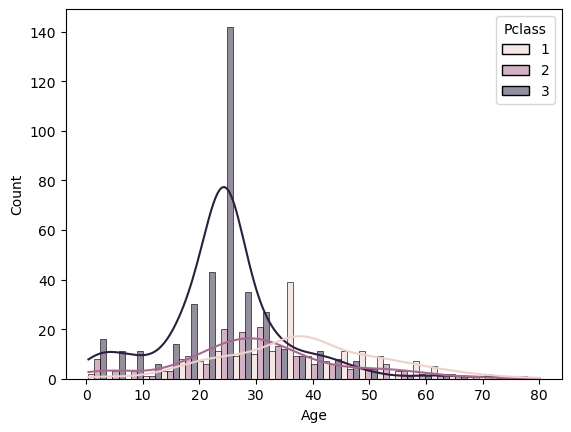

In [253]:
# We can re-use the MarImputer transformer to fill missing ages based on the mean Age of each PClass! 
# plot histogram of age after transformation to cmpare with my results 

age_imputer = MARImputer(corr_feature="Pclass", dep_feature="Age", agg=pd.Series.mean)

train_df = age_imputer.fit_transform(train_df)
test_df = age_imputer.transform(test_df)

sns.histplot(train_df, x="Age", kde=True, hue='Pclass', multiple='dodge')

In [254]:
# For Embarked, we will simply fill with UNK token again
# Print missing values again to confirm we have successfully filled all NaNs
train_df['Embarked'] = train_df['Embarked'].fillna(value="UNK")
test_df['Embarked'] = test_df['Embarked'].fillna(value="UNK")
train_df.isna().sum().sort_values(ascending=False)

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
Deck        0
Surname     0
Title       0
dtype: int64

### Categorical Feature Encoding


In [255]:
# Which remaining columns need encoding? Display all object type columns in train_df:
cols = train_df.select_dtypes("O").columns.tolist()
cols

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Deck', 'Surname', 'Title']

In [256]:
# display number of unique values per column above

for c in cols:
    print(f"{c}: {len(train_df[c].unique())}")

Name: 712
Sex: 2
Ticket: 562
Cabin: 121
Embarked: 4
Deck: 7
Surname: 553
Title: 16


In [257]:
# Drop `Ticket`, "Surname", and `Name` columns from both dataframes. Display train_df shape

train_df = train_df.drop(columns=["Ticket", "Name", "Surname"])
test_df = test_df.drop(columns=["Ticket", "Name", "Surname"])

train_df.shape

(712, 11)

In [258]:
# TODO: Relection: Last time we concluded that none of these were ordinal features. What about Deck?

In [259]:
# Encode all ['Sex', 'Cabin', 'Embarked', 'Title'] using ohe_encoding func 
# we defined above. 
# Display new train_df_encoded shape
cols = ['Sex', 'Cabin', 'Embarked', 'Title', "Surname"]

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int8).set_output(transform="pandas")
# NOTE: We need to set handle_unknown to 'ignore' since many cabins from test are not found in train
ohe.fit(train_df[cols])
train_df_encoded = ohe_encoding(train_df, ohe, cols)
test_df_encoded = ohe_encoding(test_df, ohe, cols)  
train_df_encoded.shape

(712, 150)

In [260]:
# Use OrdinalEnoder for Deck:
# NOTE: .fit expects shape of (n_smaples, n_features). Can use df[[col]] syntax or ColumnTransformer
# NOTE: Some Decks in test not found in train, use 
# handle_unknown="use_encoded_value", unknown_value=-1 as arguments for Ordinal encoder
# TODO: display train_df_encoded["Deck"]

categories = [np.sort(train_df_encoded['Deck'].unique())]
deck_encoder = OrdinalEncoder(categories=categories, handle_unknown="use_encoded_value", unknown_value=-1, dtype=np.int8)
train_df_encoded["Deck"] = deck_encoder.fit_transform(train_df_encoded[['Deck']])
test_df_encoded["Deck"] = deck_encoder.transform(test_df_encoded[['Deck']])
train_df_encoded["Deck"]

PassengerId
710    6
440    6
841    6
721    0
40     6
      ..
506    2
640    6
879    6
825    4
804    6
Name: Deck, Length: 712, dtype: int8

### Feature Engineering

In [261]:
# Let's create a binary feature called "has_family" that is true if parch OR sibsp >1

# SPACESHIP EXAMPLE
# NOTE: Can be done in a single line with lambda

def spent_money(row):
    cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    if row[cols].sum()>1:
        return True
    else:
        return False
    
space_df['spent_money'] = space_df.apply(spent_money, axis=1)
space_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'spent_money']]

RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  spent_money
PassengerId                                                                   
0001_01              0.0        0.0           0.0     0.0     0.0        False
0002_01            109.0        9.0          25.0   549.0    44.0         True
0003_01             43.0     3576.0           0.0  6715.0    49.0         True
0003_02              0.0     1283.0         371.0  3329.0   193.0         True
0004_01            303.0       70.0         151.0   565.0     2.0         True
...                  ...        ...           ...     ...     ...          ...
9276_01              0.0     6819.0           0.0  1643.0    74.0         True
9278_01              0.0        0.0           0.0     0.0     0.0        False
9279_01              0.0        0.0        1872.0     1.0     0.0         True
9280_01              0.0     1049.0           0.0   353.0  3235.0         True
9280_02            126.0     4688.0           0.0     0.0    12.0         True

[8693 rows x 6 columns]

In [262]:
# Let's create a binary feature called "has_family" that is true if Parch OR SibSp >1
# NOTE: Don't forget test_df_encoded 
# TODO: display train_df_encoded[['Parch', 'SibSp', 'has_family']]

train_df_encoded['has_family'] = train_df_encoded.apply(lambda row: True if row[["Parch", "SibSp"]].sum()>0 else False, axis=1)
test_df_encoded['has_family'] = test_df_encoded.apply(lambda row: True if row[["Parch", "SibSp"]].sum()>0 else False, axis=1)
train_df_encoded[['Parch', 'SibSp', 'has_family']]

Parch  SibSp  has_family
PassengerId                          
710              1      1        True
440              0      0       False
841              0      0       False
721              1      0        True
40               0      1        True
...            ...    ...         ...
506              0      1        True
640              0      1        True
879              0      0       False
825              1      4        True
804              1      0        True

[712 rows x 3 columns]

### Modelling and scaling

In [263]:
# Split data
X_train = train_df_encoded.drop(columns=["Survived"])
y_train = train_df_encoded["Survived"]
X_test = test_df_encoded.drop(columns=["Survived"])
y_test = test_df_encoded["Survived"]

In [264]:
# Final step! Let's try using a standard scaler fit to train_df_encoded
# TODO: Call .describe on train_df_encoded
X_train.describe()

Pclass         Age       SibSp       Parch        Fare        Deck  \
count  712.000000  712.000000  712.000000  712.000000  712.000000  712.000000   
mean     2.313202   29.087701    0.519663    0.411517   33.001761    4.469101   
std      0.832832   13.587005    1.078967    0.833903   52.353275    2.043590   
min      1.000000    0.420000    0.000000    0.000000    0.000000    0.000000   
25%      2.000000   22.000000    0.000000    0.000000    7.925000    3.000000   
50%      3.000000   25.000000    0.000000    0.000000   14.500000    6.000000   
75%      3.000000   36.625000    1.000000    1.000000   31.068750    6.000000   
max      3.000000   80.000000    8.000000    6.000000  512.329200    6.000000   

       Sex_female    Sex_male   Cabin_A10   Cabin_A19  ...  Title_Major  \
count  712.000000  712.000000  712.000000  712.000000  ...   712.000000   
mean     0.355337    0.644663    0.001404    0.001404  ...     0.002809   
std      0.478952    0.478952    0.037477    0.037477  ...     0.052963   
min      0.000000    0.000000    0.000000    0.000000  ...     0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...     0.000000   
50%      0.000000    1.000000    0.000000    0.000000  ...     0.000000   
75%      1.000000    1.000000    0.000000    0.000000  ...     0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...     1.000000   

       Title_Master  Title_Miss  Title_Mlle   Title_Mme    Title_Mr  \
count    712.000000  712.000000  712.000000  712.000000  712.000000   
mean       0.049157    0.199438    0.002809    0.001404    0.568820   
std        0.216348    0.399859    0.052963    0.037477    0.495589   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.000000    0.000000    0.000000    0.000000    0.000000   
50%        0.000000    0.000000    0.000000    0.000000    1.000000   
75%        0.000000    0.000000    0.000000    0.000000    1.000000   
max        1.000000    1.000000    1.000000    1.000000    1.000000   

        Title_Mrs    Title_Ms   Title_Rev   Title_Sir  
count  712.000000  712.000000  712.000000  712.000000  
mean     0.147472    0.001404    0.008427    0.001404  
std      0.354825    0.037477    0.091475    0.037477  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000    1.000000  

[8 rows x 149 columns]

In [265]:
space_df

HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
PassengerId                                                              
0001_01         Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
0002_01          Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
0003_01         Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
0003_02         Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
0004_01          Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...                ...       ...       ...            ...   ...    ...   
9276_01         Europa     False    A/98/P    55 Cancri e  41.0   True   
9278_01          Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
9279_01          Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
9280_01         Europa     False   E/608/S    55 Cancri e  32.0  False   
9280_02         Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   
...                  ...        ...           ...     ...     ...   
9276_01              0.0     6819.0           0.0  1643.0    74.0   
9278_01              0.0        0.0           0.0     0.0     0.0   
9279_01              0.0        0.0        1872.0     1.0     0.0   
9280_01              0.0     1049.0           0.0   353.0  3235.0   
9280_02            126.0     4688.0           0.0     0.0    12.0   

                          Name  Transported Deck      Surname  spent_money  
PassengerId                                                                 
0001_01        Maham Ofracculy        False    B    Ofracculy        False  
0002_01           Juanna Vines         True    F        Vines         True  
0003_01          Altark Susent        False    A       Susent         True  
0003_02           Solam Susent        False    A       Susent         True  
0004_01      Willy Santantines         True    F  Santantines         True  
...                        ...          ...  ...          ...          ...  
9276_01      Gravior Noxnuther        False    A    Noxnuther         True  
9278_01        Kurta Mondalley        False    G    Mondalley        False  
9279_01           Fayey Connon         True    G       Connon         True  
9280_01       Celeon Hontichre        False    E    Hontichre         True  
9280_02       Propsh Hontichre         True    E    Hontichre         True  

[8693 rows x 16 columns]

In [266]:
## STARSHIP EXAMPLE
# Use standard scale to fit/transform X_train and transform X_test for the following columns:
# cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck']
# Can wrap with columnTransformer or make a slice as per above
ss = StandardScaler().set_output(transform="pandas")
space_df_copy = space_df.copy()
space_df_copy[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa"]] = ss.fit_transform(space_df[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa"]])
display(space_df_copy[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa"]])
#
# OR
#
from sklearn.compose import ColumnTransformer
ss = ColumnTransformer(
    transformers=[("ss", StandardScaler(), ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa"])],
)
space_df_copy[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa"]]=ss.fit_transform(space_df)
display(space_df_copy[["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa"]])

Age  RoomService  FoodCourt  ShoppingMall       Spa
PassengerId                                                          
0001_01      0.702095    -0.337025  -0.284274     -0.287317 -0.273736
0002_01     -0.333233    -0.173528  -0.278689     -0.245971  0.209267
0003_01      2.013510    -0.272527   1.934922     -0.287317  5.634034
0003_02      0.287964    -0.337025   0.511931      0.326250  2.655075
0004_01     -0.885407     0.117466  -0.240833     -0.037590  0.223344
...               ...          ...        ...           ...       ...
9276_01      0.840138    -0.337025   3.947464     -0.287317  1.171754
9278_01     -0.747364    -0.337025  -0.284274     -0.287317 -0.273736
9279_01     -0.195189    -0.337025  -0.284274      2.808634 -0.272856
9280_01      0.218942    -0.337025   0.366715     -0.287317  0.036829
9280_02      1.047204    -0.148029   2.625008     -0.287317 -0.273736

[8693 rows x 5 columns]

Age  RoomService  FoodCourt  ShoppingMall       Spa
PassengerId                                                          
0001_01      0.702095    -0.337025  -0.284274     -0.287317 -0.273736
0002_01     -0.333233    -0.173528  -0.278689     -0.245971  0.209267
0003_01      2.013510    -0.272527   1.934922     -0.287317  5.634034
0003_02      0.287964    -0.337025   0.511931      0.326250  2.655075
0004_01     -0.885407     0.117466  -0.240833     -0.037590  0.223344
...               ...          ...        ...           ...       ...
9276_01      0.840138    -0.337025   3.947464     -0.287317  1.171754
9278_01     -0.747364    -0.337025  -0.284274     -0.287317 -0.273736
9279_01     -0.195189    -0.337025  -0.284274      2.808634 -0.272856
9280_01      0.218942    -0.337025   0.366715     -0.287317  0.036829
9280_02      1.047204    -0.148029   2.625008     -0.287317 -0.273736

[8693 rows x 5 columns]

In [267]:
# Use standard scale to fit/transform X_train and transform X_test for the following columns:
# cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck']
# Can wrap with columnTransformer or make a slice as per above
# TODO: Call .describe on X_train

ss = StandardScaler().set_output(transform="pandas")
X_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck']] = ss.fit_transform(X_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck']])
X_test[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck']] = ss.transform(X_test[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck']])
X_train.describe()
# ss = StandardScaler().set_output(transform="pandas")
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

Pclass           Age         SibSp         Parch          Fare  \
count  7.120000e+02  7.120000e+02  7.120000e+02  7.120000e+02  7.120000e+02   
mean   1.995907e-17  4.490790e-17 -9.979533e-18  1.995907e-17  6.237208e-17   
std    1.000703e+00  1.000703e+00  1.000703e+00  1.000703e+00  1.000703e+00   
min   -1.577900e+00 -2.111419e+00 -4.819686e-01 -4.938297e-01 -6.308098e-01   
25%   -3.763334e-01 -5.220196e-01 -4.819686e-01 -4.938297e-01 -4.793280e-01   
50%    8.252333e-01 -3.010652e-01 -4.819686e-01 -4.938297e-01 -3.536506e-01   
75%    8.252333e-01  5.551332e-01  4.454953e-01  7.061933e-01 -3.694840e-02   
max    8.252333e-01  3.749766e+00  6.937743e+00  6.706308e+00  9.162071e+00   

               Deck  Sex_female    Sex_male   Cabin_A10   Cabin_A19  ...  \
count  7.120000e+02  712.000000  712.000000  712.000000  712.000000  ...   
mean   2.744372e-17    0.355337    0.644663    0.001404    0.001404  ...   
std    1.000703e+00    0.478952    0.478952    0.037477    0.037477  ...   
min   -2.188425e+00    0.000000    0.000000    0.000000    0.000000  ...   
25%   -7.193880e-01    0.000000    0.000000    0.000000    0.000000  ...   
50%    7.496490e-01    0.000000    1.000000    0.000000    0.000000  ...   
75%    7.496490e-01    1.000000    1.000000    0.000000    0.000000  ...   
max    7.496490e-01    1.000000    1.000000    1.000000    1.000000  ...   

       Title_Major  Title_Master  Title_Miss  Title_Mlle   Title_Mme  \
count   712.000000    712.000000  712.000000  712.000000  712.000000   
mean      0.002809      0.049157    0.199438    0.002809    0.001404   
std       0.052963      0.216348    0.399859    0.052963    0.037477   
min       0.000000      0.000000    0.000000    0.000000    0.000000   
25%       0.000000      0.000000    0.000000    0.000000    0.000000   
50%       0.000000      0.000000    0.000000    0.000000    0.000000   
75%       0.000000      0.000000    0.000000    0.000000    0.000000   
max       1.000000      1.000000    1.000000    1.000000    1.000000   

         Title_Mr   Title_Mrs    Title_Ms   Title_Rev   Title_Sir  
count  712.000000  712.000000  712.000000  712.000000  712.000000  
mean     0.568820    0.147472    0.001404    0.008427    0.001404  
std      0.495589    0.354825    0.037477    0.091475    0.037477  
min      0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000  
50%      1.000000    0.000000    0.000000    0.000000    0.000000  
75%      1.000000    0.000000    0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000    1.000000    1.000000  

[8 rows x 149 columns]

In [268]:
# Get models by calling get_models_dict
models_dict = get_models_dict()

In [269]:
# Fit and evaluate models using fit_validate_model()

data = [X_train, X_test, y_train, y_test]
engineered_metrics = {}
for name, model in models_dict.items():
    engineered_metrics[name] = fit_validate_model(model, name, *data)

Accuracy   ROC_AUC                    Name
1  0.843575  0.881916  RandomForestClassifier
0  0.837989  0.896896      LogisticRegression
2  0.832402  0.875843           XGBClassifier
4  0.821229  0.902294                     SVC
3  0.659218  0.833131              GaussianNB

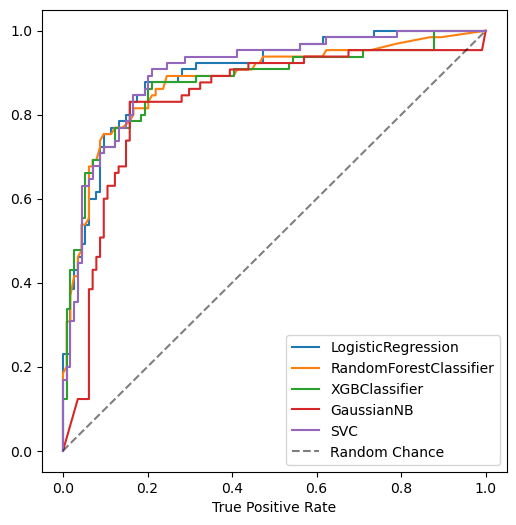

In [270]:
# Display all metrics using `ModelMetrics.display_all``
ModelMetrics.display_all(engineered_metrics)

Accuracy   ROC_AUC                          Name
1  0.860335  0.876721  RandomForestClassifier_naive
6  0.843575  0.881916        RandomForestClassifier
5  0.837989  0.896896            LogisticRegression
7  0.832402  0.875843                 XGBClassifier
2  0.826816  0.863698           XGBClassifier_naive
9  0.821229  0.902294                           SVC
0  0.804469  0.871255      LogisticRegression_naive
4  0.687151  0.737652                     SVC_naive
3  0.664804  0.828138              GaussianNB_naive
8  0.659218  0.833131                    GaussianNB

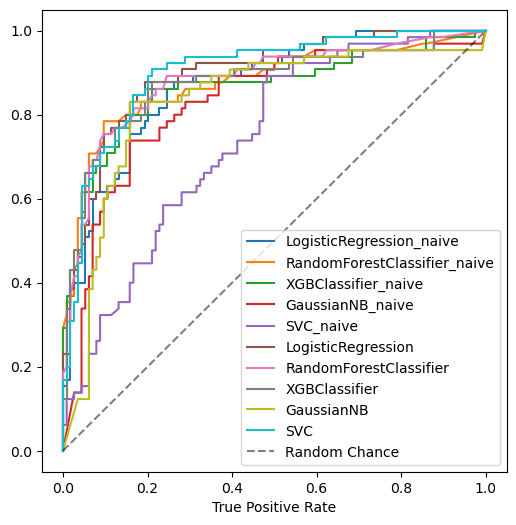

In [271]:
### Optional: Compare naive vs. engineered_metrics by joining dict and calling display_all on merged metrics. 

combined_metrics = {f"{k}_naive": v for k,v in naive_metrics.items()}
for v in combined_metrics.values():
    v.name = v.name + "_naive"
combined_metrics.update(engineered_metrics)
ModelMetrics.display_all(combined_metrics)

# Reflection

* Which models improved? Which stayed the same or got worse?
* Would including Surname help? Try it out! 
* How to explain models with improved ROC but worse accuracy?
* Why does RF and XGB metrics remain relatively unchanged?
